In [278]:
from scipy.integrate import quad
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from math import exp
import scipy as sc
import pandas as pd

## **Problème 2** : Calibrations d'hyper-paramètres d'une regression de processus gaussien par maximum de vraissemblance.

In [279]:
def cov_k(x0, x1, lambd = 0.1) :
    return (1+ ((abs(x0 - x1))/lambd) + (((abs(x0-x1))**2)/(3*(lambd**2)))) * exp(-((abs(x0-x1))/lambd))

def compute_cov_sigma(x, lambd = 0.1) :
    return np.array([[cov_k(xi, xj, lambd) for xj in x] for xi in x])

### 1. Simulation de plusieurs réalisations d'un processus Gaussien de moyenne nulle et de fonction de covariance $k_1$
####    1.a. Moyenne et matrice de covariance du vecteur aléatoire $m + L^tG$
- Prenons $N$ valeurs équi-distribuées avec $x_i \in [0,1]$ tels que $x_1 < \dots < x_N$.
- Fixons $\lambda = 1$ et calculons $\Sigma$, la matrice de covariance 

In [280]:
N = 1000

_out = True
if N > 50 :
    _out = False

lambd = 0.1

#To get N numbers evenly spread between 0 and 1, linspace() from numpy
xi = np.linspace(0, 1, N)
sigma = compute_cov_sigma(xi, lambd=lambd)

if(_out) :
    print("xi : ", xi.round(2))
    print("Sigma :")
    print(sigma.round(3))
else:
    print("xi and Sigma computed !")

xi and Sigma computed !


- Calculons $L$, la décomposition de Cholesky de $\Sigma$
- Prenons $G$, un vecteur de taille $N$ dont les valeurs sont des tirages aléatoires indépendants d'une loi Gausienne centrée réduite
- Notons $m = (m(x_1), \dots, m(x_N))$ (que l'on considère non nul uniquement pour cette question)

In [281]:
L = la.cholesky(sigma)
# P, L, U = sc.linalg.lu(sigma)

G = np.random.normal(0, 1, N)

if _out :
    print("L :\n", L.round(2))
    print("G :\n", G.round(2))
else :
    print("L and G computed !")

L and G computed !


Avec ces élements, calculons le vecteur aléatoire *$m + L^tG$*, que nous noterons $v$ pour cette question.

Nous allons nous intéresser à la moyenne et la matrice de covariance de ce vecteur.

soit le théorème de la fonction caractéristique d'un vecteur Guassien et sa corollaire de linéarité :

![Propriétés des vecteurs gaussiens](resources/fct_carac_guass.png)

et sachant que G est un vecteur dont les coordonnées sont des gaussiennes centrées, réduites et indépendantes,
Il en découle que pour le vecteur *$v=m + L^tG$* 
$$
\begin{array}{l}
\text { Soit } G=\left(G_{1}, \quad G_{N}\right) \sim \mathcal{N}{(0, I)}\\
m+L{ }^{t} G \sim \mathcal{N}\left(L. moy(G)+m , L \sum^{t} L\right)\\
\text { or } moy(G)=0\\
 \rightarrow m+L{ }^{t} G \sim \mathcal{N}\left(m, L \sum{ }^{t} L\right)
\end{array}
$$

#### 1.b. Simulation d'un vecteur gaussien
Nous allons simuler $g =  (g_1, \dots, g_N)$ une réalisation de $G$ et calculer le vecteur $(z_1, \dots, z_N) = L^tg$.

#### 1.c. Etude numérique de la simulation 
Nous allons ensuite tracer le graphe $(x_i, z_i)_{i=1, \dots, N}$ qui représente une réalisation du processus Gaussien $Z$ pour une valeur de paramètre $\lambda=1$

#### 1.d. Réitération de la simulation
Enfin, nous allons réaliser (b) plusieurs fois, et représenter sur le même graphe les différentes réalisation de $Z$

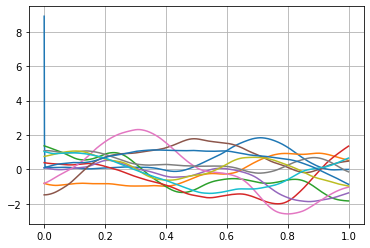

In [282]:
#1.b
g = np.random.normal(0, 1, N)

z = L.T @ g
    
#1.c
plt.plot(xi, z)

#1.d
for i in range(10) :
    g = np.random.normal(0, 1, N)
    z = L @ g
    plt.plot(xi, z)
    
plt.grid()


Voici le graphe montrant plusieurs réalisations du processus (avec $\lambda=1$). Comme on peut le constater, aucune courbe n'est superposée car il s'agit d'un processus aléatoire.

#### 1.e. Changement du paramètre $\lambda$
Nous allons maintenant réitérer l'expérience ci-dessus (questions(a) à (d)) en changeant la valeur du paramètre $\lambda$, initialement fixé à 1.

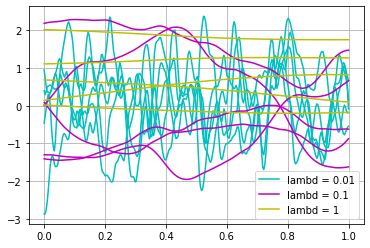

In [283]:
N = 299

_out = True
if N > 50 :
    _out = False

lambd = 100

#To get N numbers evenly spread between 0 and 1, linspace() from numpy
lambds = [0.01, 0.1, 1]
colors = [ 'c', 'm', 'y', 'b', 'g', 'r', 'k', 'w']

for lambd, c in zip(lambds, colors) :
    xi = np.linspace(0, 1, N)
    sigma = compute_cov_sigma(xi, lambd=lambd)
    L = la.cholesky(sigma)
    
    plt.plot(0, c+'-', label="lambd = "+str(lambd))
    for i in range(5) :
        g = np.random.normal(0, 1, N)
        z = L @ g
        plt.plot(xi, z, c+'-')
plt.grid()
plt.legend()

On constate qu'en augmentant le paramètre $\lambda$, la courbe devient de plus en plus "lisse", jusqu'à devenir linéaire quand $\lambda=1$.

Cependant, la fonction de covariance n'est pas parfaitement symétrique. En effet, en fonction de la valeur de $\lambda$ et de $N$, $\Sigma$ n'est pas toujours définie positive, et donc on ne peut pas faire une factorisation Cholesky, ce qui pose problème pour la suite. C'est pourquoi nous avons gardé $N < 300$.


### 2. Estimation du paramètre $\lambda$ par maximum de vraissemblance

#### 2.a Diviser [0,1] en $N =10$ interalles et tirez un nombre uniformément dans chacun d'entre eux.
On notera $x_1,\dots ,x_N$ ces valeurs

In [284]:
N = 1000

part = np.linspace(0, 1, N+1)
xi = []

for b in list(zip(part[::1],part[1::1])):
    xi.append(np.random.uniform(b[0], b[1]))

#### 2.b Soit $z = (z_1, \dots ,z_n)$ le vecteur de taille $N$ défini pour tout $i$ par $z_i = sin(4\pi x_i)$

Étudions la négative log-vraissemblance associée au vecteur aléatoire Gaussien $(Z(x_1), \dots , Z(x_n))$ dont $z$ est une réalisation. Il s'agit une fonction paramétrée par $\lambda$

Ensuite, à l'aide d'un optimiseur, nous allons minimisez cette négative log-vraissemblance par rapport à $\lambda$

Visualisons d'abord les données

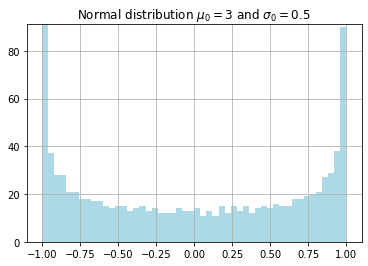

In [285]:
from math import sin, pi

z = []

for x in xi :
    z.append(sin(4*pi*x))

hx, hy, _ = plt.hist(z, bins=50,color="lightblue")

plt.ylim(0.0,max(hx)+0.05)
plt.title(r'Normal distribution $\mu_0 = 3$ and $\sigma_0 = 0.5$')
plt.grid()

plt.show()

3168.810849679093


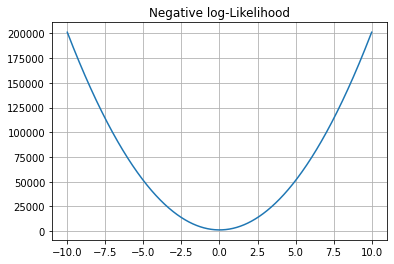

In [286]:
import scipy.stats

# scipy.stats.norm.pdf(6,2.0,1.0)

print( -np.log(scipy.stats.norm.pdf(z,2.0,1.0)).sum() )

x = np.linspace(-10, 10, 1000, endpoint=True)

y = []
for i in x:
    y.append(-np.log(scipy.stats.norm.pdf(z,i,0.5)).sum())

plt.plot(x,y)

plt.title('Negative log-Likelihood')
plt.grid()

#plt.show()

In [287]:
y_min = y.index(min(y))
print('Minimum reached on y =', x[y_min])
y_min = x[y_min]

Minimum reached on y = 0.010010010010010006


#### 2.c Utilisation du $\lambda$ estimé en (b)

Nous allons mainteant simuler quelques réalisations du processus Gaussien $Z$ en prenant comme valeur de $\lambda$ la valeur optimale trouvée dans la question précédente, c'est à dire la valeur qui minimise la log-vraissemblance.

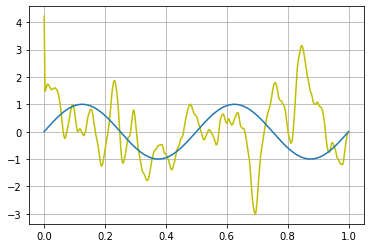

In [288]:
N = 1000

x = np.linspace(0,1, N)

ysin = []

for i in x :
    ysin.append(sin(4*pi*i))

sigma = compute_cov_sigma(x, lambd=y_min)
L = la.cholesky(sigma)

g = np.random.normal(0, 1, N)
z = L.T @ g
plt.plot(x, z, c+'-')
    
    
plt.plot(x,ysin)
plt.grid()

### 3. Simulation de plusieurs réalisations d'un processus Gaussien conditionné à un ensemble de données
<!-- #### 3.a Pour un $x \in [0,1]$, rappelons la moyenne et la variance de $Z(x)$ -->
#### 3.a Calcul de moyenne et variance



In [ ]:
def mu(z, xi):
    return 0

#### 3.b Tracer sur un graphe $sin(4\pi x)$, la moyenne $\mu_n (x)$, ainsi que $\mu_n(x) + 2\sigma_n^2(x)$ et $\mu_n(x) - 2\sigma_n^2(x)$ 

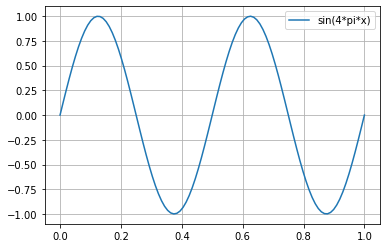

In [290]:
xi = np.linspace(0,1,100)
yi = []
for x in xi:
    yi.append(sin(4*pi*x))
    

plt.plot(xi,yi, label="sin(4*pi*x)")
plt.legend()
plt.grid()

#### 3.c Tracer un ensemble de réalisations du processus a posteriori ainsi que $sin(4\pi x)$